In [1]:
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import warnings
from lightgbm import LGBMRegressor
from pmdarima.arima import AutoARIMA
from mpire import WorkerPool
from threadpoolctl import threadpool_limits
from skforecast.preprocessing import RollingFeatures, series_long_to_dict
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirect

/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# CONFIG

NUM_CPU_CORES = multiprocessing.cpu_count()
# Forecast 13 weeks ahead into the future
FORECAST_PERIOD = 13
TARGET_COL = 'sales_qty'
RANDOM_SEED = 123

In [3]:
sales_df = pd.read_csv("../data/phase0_sales.csv")
list_columns = list(sales_df.columns)
list_dates_columns = list_columns[3:]

# Unpivot to get flat format dataframe
sales_df = sales_df.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='date_key', 
                         value_vars=list_dates_columns, value_name=TARGET_COL)


# Create new delimiter column to form unique identifier
sales_df['item_id'] = sales_df[['Client', 'Warehouse', 'Product']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
sales_df['date_key'] = pd.to_datetime(sales_df['date_key']).dt.date

In [10]:
# Baseline forecasting:

def _baseline_forecast(id, df, forecast_periods, baseline_type, target_col='target_col'):
    # 1. Last Known Value forecaster
    if baseline_type == 'last_known_value':
        forecaster = ForecasterEquivalentDate(
                        offset=1,
                        n_offsets=1
                     )
    # 2. 3 Weeks MA forecaster
    elif baseline_type == 'moving_average':
        forecaster = ForecasterEquivalentDate(
                        offset=1,
                        n_offsets=3,
                        agg_func=np.mean
                    )
    forecaster.fit(y=df[target_col])
    pred = forecaster.predict(steps=forecast_periods)
    pred_df = pd.DataFrame({'forecast': pred})
    pred_df["item_id"] = id
    pred_df['date_key'] = pd.date_range(df['date_key'].max()+pd.Timedelta(weeks=1),
                                        df['date_key'].max()+pd.Timedelta(weeks=forecast_periods),
                                        freq='W-MON')
    return pred_df
    

def multi_threaded_baseline_forecast(df, baseline_type='last_known_value'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        baseline_model = functools.partial(_baseline_forecast,
                                            forecast_periods=FORECAST_PERIOD,
                                            baseline_type=baseline_type,
                                            target_col=TARGET_COL)
        with WorkerPool(n_jobs=NUM_CPU_CORES) as pool:
            list_forecast_baseline = pool.map_unordered(baseline_model, df.groupby('item_id'), progress_bar=True)
        forecast_result_baseline = pd.concat(list_forecast_baseline, axis=0)
        return forecast_result_baseline

In [14]:
forecast_result_baseline_lkv = multi_threaded_baseline_forecast(sales_df, baseline_type='last_known_value')
forecast_result_baseline_ma3 = multi_threaded_baseline_forecast(sales_df, baseline_type='moving_average')

100%|██████████| 15053/15053 [00:04<00:00, 3753.06it/s]


In [56]:
def _arima_forecast(id, df, forecast_periods, target_col='target_col'):
    # TODO: add logic for exogenous variables in ARIMA, for now, we assume the only features used are past sales
    historical_X = None
    future_X = None
    model = AutoARIMA(n_jobs = 1)
    try :
        # Limit number of threading because autoarima will use all threads even if n_jobs = 1, 
        # which lead to bottle neck when applying multiprocessing
        with threadpool_limits(limits=1, user_api='blas'):
            model.fit(y=df[target_col].values, X=historical_X)
            pred = model.predict(int(forecast_periods), X=future_X)
    # Sometime autoarima failed to find the best model, if that happen then we change the prediction into 7 week average prediction
    except Exception as e:
        print(e)
        pred = pd.Series([df[target_col].iloc[:7].mean()]*forecast_periods)
        
    pred_df = pd.DataFrame({'forecast': pred})
    pred_df["item_id"] = id
    pred_df['date_key'] = pd.date_range(df['date_key'].max()+pd.Timedelta(weeks=1),
                                        df['date_key'].max()+pd.Timedelta(weeks=forecast_periods),
                                        freq='W-MON')
    return pred_df

def multi_threaded_arima_forecast(df):
    arima_model = functools.partial(_arima_forecast,
                                   forecast_periods=FORECAST_PERIOD,
                                   target_col=TARGET_COL)
    with WorkerPool(n_jobs=NUM_CPU_CORES) as pool:
        list_forecast_arima = pool.map_unordered(arima_model, df.groupby('item_id'), progress_bar=True)
    forecast_result_arima = pd.concat(list_forecast_arima, axis=0)
    return forecast_result_arima

In [57]:
forecast_result_arima = multi_threaded_arima_forecast(sales_df)

  3%|▎         | 407/15053 [00:36<20:06, 12.14it/s]/opt/anaconda3/envs/vn1/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,1,4)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/vn1/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/envs/vn1/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/envs/vn1/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/anaconda3/envs/vn1/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/opt/anaconda3/envs/vn1/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemode

In [28]:
# Forecasting using machine learning (local LGBM):

# Local LightGBM:
def _local_lgbm_forecast(id, df, forecast_periods, model_type, target_col='target_col'):
    # 1. Recursive Multi-step Local LGBM Forecaster
    if model_type == 'recursive':
        forecaster = ForecasterRecursive(
                        regressor=LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
                        lags=10,
                        window_features=RollingFeatures(stats=['mean'], window_sizes=10)
                    )
    # 2. Direct Multi-step Local LGBM Forecaster
    elif model_type == 'direct':
        forecaster = ForecasterDirect(
                        regressor=LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
                        steps=forecast_periods,
                        lags=10,
                        window_features=RollingFeatures(stats=['mean'], window_sizes=10),
                    )
    forecaster.fit(y=df[target_col])
    pred = forecaster.predict(steps=forecast_periods)
    pred_df = pd.DataFrame({'forecast': pred})
    pred_df["item_id"] = id
    pred_df['date_key'] = pd.date_range(df['date_key'].max()+pd.Timedelta(weeks=1),
                                        df['date_key'].max()+pd.Timedelta(weeks=forecast_periods),
                                        freq='W-MON')
    return pred_df
    

def multi_threaded_local_lgbm_forecast(df, model_type='recursive'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        baseline_model = functools.partial(_local_lgbm_forecast,
                                            forecast_periods=FORECAST_PERIOD,
                                            model_type=model_type,
                                            target_col=TARGET_COL)
        with WorkerPool(n_jobs=NUM_CPU_CORES) as pool:
            list_forecast_lgbm = pool.map_unordered(baseline_model, df.groupby('item_id'), progress_bar=True)
        forecast_result_lgbm = pd.concat(list_forecast_lgbm, axis=0)
        return forecast_result_lgbm

In [29]:
forecast_result_local_lgbm_recursive = multi_threaded_local_lgbm_forecast(sales_df, model_type='recursive')
forecast_result_local_lgbm_direct = multi_threaded_local_lgbm_forecast(sales_df, model_type='direct')

100%|██████████| 15053/15053 [2:31:50<00:00,  3.82it/s]    


In [50]:
# Transform the sales dataFrame in "long format" and returns a dict of series.
series_dict = series_long_to_dict(
    data=sales_df,
    series_id='item_id',
    index='date_key',
    values='sales_qty',
    freq='W-MON'
)

In [73]:
# Forecasting using machine learning (global LGBM):

# Local LightGBM:
def global_lgbm_forecast(series_dict, forecast_periods):
    # 1. Recursive Multi-series Global LGBM Forecaster
    window_features = RollingFeatures(stats=['mean']*4, window_sizes=[1, 3, 5, 7])
    forecaster = ForecasterRecursiveMultiSeries(
                    regressor=LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
                    lags=[1,2,3,4,5],
                    window_features=window_features,
                    dropna_from_series=False
                )

    forecaster.fit(series=series_dict, suppress_warnings=True)
    forecasts_df = forecaster.predict(steps=forecast_periods)
    return forecasts_df

forecast_result_global_lgbm_recursive = global_lgbm_forecast(series_dict, FORECAST_PERIOD)

/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/vn1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

In [74]:
forecast_result_global_lgbm_recursive = forecast_result_global_lgbm_recursive.reset_index()
forecast_result_global_lgbm_recursive.rename(columns={'index': 'date_key'}, inplace=True)

In [75]:
forecast_result_global_lgbm_recursive = forecast_result_global_lgbm_recursive.melt(
        id_vars=["date_key"],
        var_name="item_id",
        value_name="forecast")

In [15]:
# forecast_result_arima.to_csv("../predictions/auto_arima.csv", index=False)
# forecast_result_baseline_lkv.to_csv("../predictions/baseline_lkv.csv", index=False)
# forecast_result_baseline_ma3.to_csv("../predictions/baseline_ma3.csv", index=False)
# forecast_result_local_lgbm_recursive.to_csv("../predictions/local_lgbm_recursive.csv", index=False)
# forecast_result_local_lgbm_direct.to_csv("../predictions/local_lgbm_direct.csv", index=False)
# forecast_result_global_lgbm_recursive.to_csv("../predictions/global_lgbm_recursive.csv", index=False)

In [106]:
forecast_result_arima = pd.read_csv("../predictions/auto_arima.csv")
forecast_result_baseline_lkv = pd.read_csv("../predictions/baseline_lkv.csv")
forecast_result_baseline_ma3 = pd.read_csv("../predictions/baseline_ma3.csv")
forecast_result_local_lgbm_recursive = pd.read_csv("../predictions/local_lgbm_recursive.csv")
forecast_result_local_lgbm_direct = pd.read_csv("../predictions/local_lgbm_direct.csv")
forecast_result_global_lgbm_recursive = pd.read_csv("../predictions/global_lgbm_recursive.csv")

In [107]:
forecast_result_arima.rename(columns={'forecast': 'forecast_arima'}, inplace=True)
forecast_result_baseline_lkv.rename(columns={'forecast': 'forecast_lkv'}, inplace=True)
forecast_result_baseline_ma3.rename(columns={'forecast': 'forecast_ma3'}, inplace=True)
forecast_result_local_lgbm_recursive.rename(columns={'forecast': 'forecast_local_lgb_recursive'}, inplace=True)
forecast_result_local_lgbm_direct.rename(columns={'forecast': 'forecast_local_lgb_direct'}, inplace=True)
forecast_result_global_lgbm_recursive.rename(columns={'forecast': 'forecast_global_lgb_recursive'}, inplace=True)

In [108]:
compiled_forecasts_df = functools.reduce(lambda left, right: pd.merge(left,right, on=['date_key', 'item_id']), 
                                         [forecast_result_arima, forecast_result_baseline_lkv, forecast_result_baseline_ma3,
                                          forecast_result_local_lgbm_recursive, forecast_result_local_lgbm_direct, 
                                         forecast_result_global_lgbm_recursive])

In [125]:
compiled_forecasts_df['date_key'] = pd.to_datetime(compiled_forecasts_df['date_key']).dt.date

In [115]:
labels_df = pd.read_csv("../data/phase1_sales.csv")
list_columns = list(labels_df.columns)
list_dates_columns = list_columns[3:]

# Unpivot to get flat format dataframe
labels_df = labels_df.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='date_key', 
                           value_vars=list_dates_columns, value_name=TARGET_COL)

In [116]:
# Create new delimiter column to form unique identifier
labels_df['item_id'] = labels_df[['Client', 'Warehouse', 'Product']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
labels_df['date_key'] = pd.to_datetime(labels_df['date_key']).dt.date

In [118]:
labels_df = labels_df[['item_id', 'date_key', 'sales_qty']]


In [126]:
merged_forecasts_labels = compiled_forecasts_df.merge(labels_df, on=['item_id', 'date_key'])

In [129]:
forecast_columns = [c for c in merged_forecasts_labels.columns if 'forecast' in c]

In [128]:
def evaluate_wape(targets, predictions):
    '''
    Returns a WAPE value (Weighted Average Percentage Error)
        Parameters:
            1. targets: A numpy array containing target values
            2. predictions: A numpy array containing forecasts

        Returns:
            wape: WAPE of predictions vs targets
    '''
    resids_summed = np.sum(abs(targets-predictions))
    targets_summed = np.sum(targets)
    if targets_summed == 0:
        return np.nan
    wape = resids_summed/targets_summed
    return wape

In [159]:
class Evaluator:
    def __init__(self, df, prediction_cols, 
                 group_cols_lst, 
                 target_col,
                 eval_funcs):
        '''
        Parameters:
                1. df: A pandas dataframe to apply evaluation on
                2. prediction_cols: A list of column names containing predictions to evaluate
                3. group_cols_lst: A list of column names to act as index to aggregate evaluation results against
                4. target_col: Name of target col to evaluate against
                5. eval_func: Evaluation function to apply on predictions and target col

        '''
        self.df = df
        self.prediction_cols = prediction_cols
        self.group_cols_lst = group_cols_lst
        self.target_col = target_col
        self.eval_funcs = eval_funcs

    @staticmethod
    def evaluate_predictions(df, prediction_cols, 
                         target_col, eval_func):
        '''
        Returns a dataframe containing evaluation results of indicated prediction_cols vs target col
            Parameters:
                1. df: A grouped pandas dataframe to apply evaluation on
                2. prediction_cols: A list of column names containing predictions to evaluate
                3. target_col: Name of target col to evaluate against
                4. eval_func: Evaluation function to apply on predictions and target col

            Returns:
                results_df: Dataframe containing evaluation results
        '''
        out = []
        pred_cols = []
        for col in prediction_cols:
            out.append(eval_func(df[target_col], df[col]))
            pred_cols.append(col)

        results_df = pd.DataFrame({'eval_value': out, 'prediction_type': pred_cols})
        return results_df


    def evaluate(self):
        '''
        Returns a dataframe containing evaluation results of indicated prediction_cols vs target col
            Returns:
                eval_df: Dataframe containing evaluation results
        '''
        eval_dfs_lst = []
        for eval_func in self.eval_funcs:
            eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)
                                          .apply(lambda x : Evaluator.evaluate_predictions(x, self.prediction_cols,
                                                                                 self.target_col, 
                                                                                 eval_func))).reset_index()
            eval_df['eval_function'] = eval_func.__name__
            
            eval_dfs_lst.append(eval_df)
        eval_final_df = pd.concat(eval_dfs_lst)
        eval_final_df.sort_values(by=self.group_cols_lst, inplace=True)
        eval_final_df = eval_final_df[self.group_cols_lst + ['prediction_type', 'eval_function', 'eval_value']]
        return eval_final_df

In [187]:
merged_forecasts_labels['forecast_ens_lkv_ma3_global_lgb'] = merged_forecasts_labels[['forecast_lkv', 'forecast_ma3', 'forecast_global_lgb_recursive']].mean(axis=1)
merged_forecasts_labels['forecast_ens_arima_global_lgb'] = merged_forecasts_labels[['forecast_arima', 'forecast_global_lgb_recursive']].mean(axis=1)

In [188]:
## Create a dummy column for overall evaluation:
merged_forecasts_labels['segment'] = 'ALL'

evaluator = Evaluator(merged_forecasts_labels, 
                     forecast_columns + ['forecast_ens_arima_global_lgb'],
                     ['segment'],
                     'sales_qty', [evaluate_wape])
eval_report = evaluator.evaluate()

/var/folders/hj/c0k0z_096_n1727t5kbgcvxm0000gn/T/ipykernel_53506/3134212166.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)


In [189]:
eval_report.rename(columns={'prediction_type': 'model',
                            'eval_value': 'WAPE'}, inplace=True)
eval_report['WAPE'] = eval_report['WAPE'].round(3)
eval_report['eval_function'] = 'WAPE'

In [177]:
eval_report.to_csv("../results/overall_eval_results.csv", index=False)

In [150]:
def label_demand_type(ts_series):
    '''
    Returns a string indication the time series classification of a series
    There are 5 possible labels, 'Unknown', 'Intermittent', 'Lumpy', 'Smooth', 'Erratic'
        Parameters:
            1. ts_series: A pandas series containing time series to be classified

        Returns:
            ts_label: Time series label
    '''
    if any(ts_series.isna()):
        return "Unknown"
    
    length = ts_series['length']
    summed = ts_series['summed']
    std = ts_series['std']
    mean = ts_series['mean']
    
    if summed == 0 or mean == 0:
        ts_label = "Unknown"
    else:
        adi = length/summed
        cv2 = std/mean
        if adi >= 1.32:
            if cv2 < 0.49:
                ts_label = "Intermittent"
            else:
                ts_label = "Lumpy"
        elif cv2 < 0.49:
            ts_label = "Smooth"
        else:
            ts_label = "Erratic"
    return ts_label

def get_demand_type_flag(df, 
                         target_col, 
                         idx_cols, 
                         output_col) -> pd.DataFrame:
    '''
    Returns a dataframe containing time series classifications based on volatility and intermittency
    There are 5 possible labels, 'Unknown', 'Intermittent', 'Lumpy', 'Smooth', 'Erratic'
        Parameters:
            1. df: A grouped pandas dataframe to apply evaluation on
            2. target_col: Name of target col to do time series classification
            3. idx_cols: List of columns to aggregate against before ts classification
                                     (for eg: ['product_id', 'warehouse_id'])
            4. output_col: Name of output column containing flag generated

        Returns:
            df_result: Dataframe containing time series classification results
    '''
    df_agg = df.groupby(idx_cols).agg(
        length = (target_col, lambda x : len(x)),
        summed = (target_col, lambda x : sum(x > 0)),
        std = (target_col, lambda x : (x[x>0].std(ddof = 0))),
        mean = (target_col, lambda x : x[x>0].mean())
    )
    df_agg[output_col] = df_agg.apply(label_demand_type, axis = 1)
    df_result = df_agg.reset_index()[idx_cols + [output_col]]
    return df_result

demand_type_df = get_demand_type_flag(sales_df, TARGET_COL, ['item_id'], 'demand_type')

In [154]:
merged_forecasts_labels = merged_forecasts_labels.merge(demand_type_df, on='item_id', how='left')
merged_forecasts_labels['demand_type'] = merged_forecasts_labels['demand_type'].fillna("Unknown")

In [185]:
demand_type_stats_df = merged_forecasts_labels.groupby("demand_type").agg({'item_id': lambda x: x.nunique(),
                                                    'sales_qty': 'sum'}).reset_index()

demand_type_stats_df.rename(columns={'item_id': 'num_items',
                                     'sales_qty': 'total_sales_qty'}, inplace=True)

demand_type_stats_df['num_items_perc'] = (demand_type_stats_df['num_items'] / demand_type_stats_df['num_items'].sum()).round(2)
demand_type_stats_df['sales_qty_perc'] = (demand_type_stats_df['total_sales_qty'] / demand_type_stats_df['total_sales_qty'].sum()).round(2)
demand_type_stats_df

,demand_type,num_items,total_sales_qty,num_items_perc,sales_qty_perc
0,Erratic,1311,881571.0,0.09,0.23
1,Intermittent,5720,697997.0,0.38,0.18
2,Lumpy,7614,1650672.0,0.51,0.42
3,Smooth,408,675566.0,0.03,0.17


In [160]:
evaluator_by_demand_type = Evaluator(merged_forecasts_labels, 
                     forecast_columns,
                     ['demand_type'],
                     'sales_qty', [evaluate_wape])
eval_report_by_demand_type = evaluator_by_demand_type.evaluate()

/var/folders/hj/c0k0z_096_n1727t5kbgcvxm0000gn/T/ipykernel_53506/3134212166.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)


In [178]:
eval_report_by_demand_type.rename(columns={'prediction_type': 'model',
                            'eval_value': 'WAPE'}, inplace=True)
eval_report_by_demand_type['WAPE'] = eval_report_by_demand_type['WAPE'].round(3)
eval_report_by_demand_type['eval_function'] = 'WAPE'

In [179]:
eval_report_by_demand_type

,demand_type,model,eval_function,WAPE
0,Erratic,forecast_arima,WAPE,0.606
1,Erratic,forecast_lkv,WAPE,0.586
2,Erratic,forecast_ma3,WAPE,0.593
3,Erratic,forecast_local_lgb_recursive,WAPE,0.658
4,Erratic,forecast_local_lgb_direct,WAPE,0.665
5,Erratic,forecast_global_lgb_recursive,WAPE,0.572
10,Intermittent,forecast_local_lgb_direct,WAPE,0.547
9,Intermittent,forecast_local_lgb_recursive,WAPE,0.511
11,Intermittent,forecast_global_lgb_recursive,WAPE,0.467
7,Intermittent,forecast_lkv,WAPE,0.425


In [180]:
eval_report_by_demand_type.to_csv("../results/eval_results_by_demand_type.csv", index=False)

In [192]:
for fc in forecast_columns:
    model = fc.split("_")[1]
    merged_forecasts_labels[f'error_{model}'] = abs(merged_forecasts_labels['sales_qty'] - merged_forecasts_labels[fc])

In [198]:
error_columns = [c for c in merged_forecasts_labels.columns if 'error' in c]
item_wise_errors = merged_forecasts_labels.groupby(['item_id', 'demand_type']).agg({k: 'sum' for k in error_columns}).reset_index()

In [200]:
item_wise_errors.query("demand_type == 'Erratic'").sort_values(by='error_arima', ascending=False)

,item_id,demand_type,error_arima,error_lkv,error_ma3,error_local,error_global
678,0_3_1154,Erratic,27141.587831,20427.0,20872.666667,26808.041613,20484.075032
5751,22_265_6181,Erratic,22545.352412,22980.0,24354.000000,27261.018965,24187.409680
9898,38_68_9805,Erratic,13620.301675,12586.0,13022.333333,14155.871184,12756.262807
9893,38_68_7768,Erratic,12481.771874,12279.0,12585.000000,14814.097480,13107.046204
9871,38_68_10088,Erratic,12479.000267,12538.0,13432.666667,12580.817857,12426.340104
...,...,...,...,...,...,...,...
9285,33_315_10906,Erratic,0.086090,0.0,0.000000,142.196372,6.768414
3496,18_177_11757,Erratic,0.047633,0.0,0.000000,18.869360,6.768414
5706,22_265_12446,Erratic,0.000000,0.0,0.000000,291.343042,6.768414
777,0_44_5147,Erratic,0.000000,0.0,0.000000,36.087087,115.049593


In [211]:
item_wise_errors.query("demand_type == 'Intermittent'").sort_values(by='error_global', ascending=False)

,item_id,demand_type,error_arima,error_lkv,error_ma3,error_local,error_global
11716,42_153_7079,Intermittent,8959.242782,9157.0,9507.000000,9208.086656,9423.357390
7211,26_74_4513,Intermittent,9341.763239,9125.0,9508.333333,9367.459133,9389.548957
9827,38_298_4902,Intermittent,5055.780850,4402.0,4401.000000,4517.182569,4775.580758
9266,32_69_12369,Intermittent,4145.570116,4590.0,4084.666667,3504.260064,4041.452605
5711,22_265_13101,Intermittent,3843.892779,3740.0,3996.000000,3875.494695,3863.636769
...,...,...,...,...,...,...,...
5199,20_221_5303,Intermittent,6.000000,6.0,6.333333,6.000000,5.657709
9590,34_325_6630,Intermittent,7.545323,8.0,7.000000,7.510210,5.638033
1683,12_57_14302,Intermittent,5.133123,5.0,5.000000,5.020270,5.499991
4582,1_75_14146,Intermittent,4.870778,8.0,6.000000,4.445229,5.360278


In [234]:
item_wise_errors.sort_values(by='error_local', ascending=False)

,item_id,demand_type,error_arima,error_lkv,error_ma3,error_local,error_global
9864,38_63_7889,Lumpy,2.207009e+04,11733.0,9865.000000,37180.304054,8185.601601
9856,38_63_12903,Lumpy,7.766959e+03,9315.0,9481.000000,31734.455694,11625.323522
12159,44_319_3445,Lumpy,1.549224e+04,12371.0,18807.000000,28713.195946,15193.938650
5751,22_265_6181,Erratic,2.254535e+04,22980.0,24354.000000,27261.018965,24187.409680
678,0_3_1154,Erratic,2.714159e+04,20427.0,20872.666667,26808.041613,20484.075032
...,...,...,...,...,...,...,...
8085,28_280_975,Intermittent,0.000000e+00,0.0,0.000000,0.000000,6.768414
8041,28_280_807,Intermittent,0.000000e+00,0.0,0.000000,0.000000,6.768414
8037,28_280_796,Intermittent,0.000000e+00,0.0,0.000000,0.000000,6.768414
8033,28_280_7848,Intermittent,0.000000e+00,0.0,0.000000,0.000000,6.768414


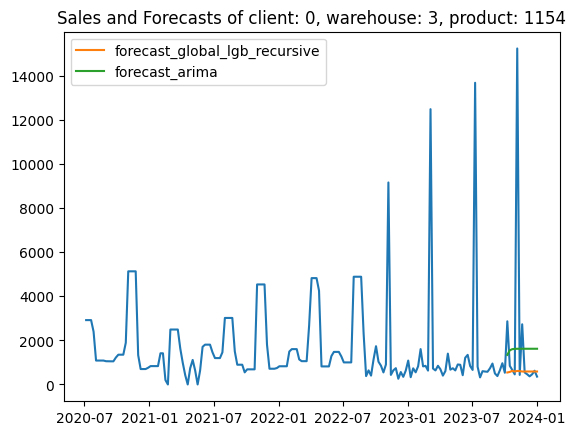

In [210]:
def visual_diagnostics(id, sales_df, forecasts_df, forecast_cols):
    client, warehouse, product = id.split("_")
    item_hist_sales_df = sales_df.query(f"item_id == '{id}'")
    item_sales_df = merged_forecasts_labels.query(f"item_id == '{id}'")
    item_sales_df = pd.concat([item_hist_sales_df[['date_key', 'sales_qty']], 
                               item_sales_df[['date_key', 'sales_qty']]])
    item_forecasts_df = merged_forecasts_labels.query(f"item_id == '{id}'")
    plt.plot(item_sales_df['date_key'], item_sales_df['sales_qty'])
    for fc in forecast_cols:
        plt.plot(item_forecasts_df['date_key'], item_forecasts_df[fc], label=fc)
    plt.title(f"Sales and Forecasts of client: {client}, warehouse: {warehouse}, product: {product}")
    plt.legend()

visual_diagnostics('0_3_1154', sales_df, forecast_result_arima, ['forecast_global_lgb_recursive', 'forecast_arima'])
    

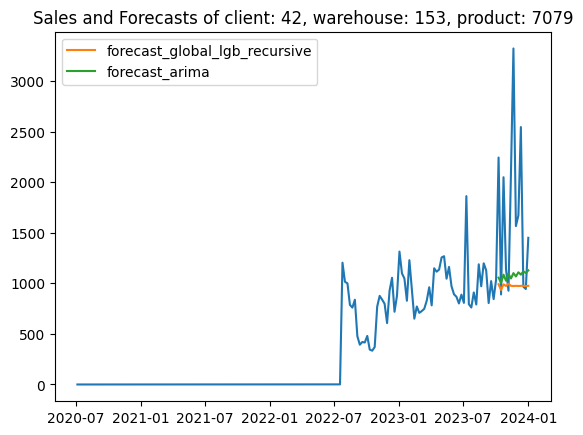

In [212]:
visual_diagnostics('42_153_7079', sales_df, forecast_result_arima, ['forecast_global_lgb_recursive', 'forecast_arima'])

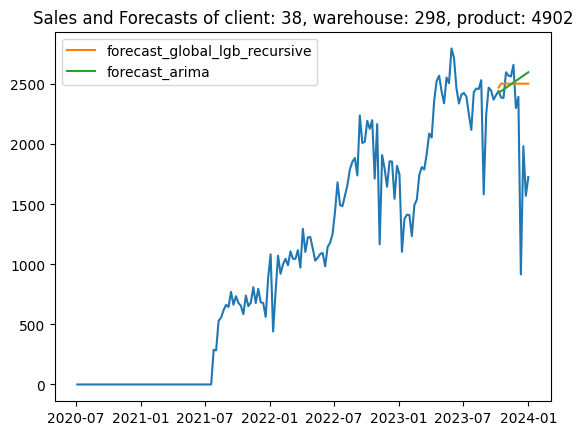

In [233]:
visual_diagnostics('38_298_4902', sales_df, forecast_result_arima, ['forecast_global_lgb_recursive', 'forecast_arima'])

In [236]:
merged_forecasts_labels

,forecast_arima,item_id,date_key,forecast_lkv,forecast_ma3,forecast_local_lgb_recursive,forecast_local_lgb_direct,forecast_global_lgb_recursive,sales_qty,segment,forecast_ens_arima_lkv_ma3_global_lgb,forecast_ens_lkv_ma3_global_lgb,demand_type,forecast_ens_arima_global_lgb,error_arima,error_lkv,error_ma3,error_local,error_global
0,2.624282,0_100_10705,2023-10-09,3.0,3.333333,2.523794,2.535456,3.622971,2.0,ALL,3.145146,3.318768,Smooth,3.123626,0.624282,1.0,1.333333,0.535456,1.622971
1,2.895353,0_100_10705,2023-10-16,3.0,3.333333,2.380753,1.618182,4.654684,1.0,ALL,3.470843,3.662672,Smooth,3.775018,1.895353,2.0,2.333333,0.618182,3.654684
2,2.441143,0_100_10705,2023-10-23,3.0,3.333333,2.162276,2.915200,5.518240,3.0,ALL,3.573179,3.950524,Smooth,3.979691,0.558857,0.0,0.333333,0.084800,2.518240
3,2.581402,0_100_10705,2023-10-30,3.0,3.333333,0.810997,1.512699,6.162655,4.0,ALL,3.769348,4.165330,Smooth,4.372029,1.418598,1.0,0.666667,2.487301,2.162655
4,2.697748,0_100_10705,2023-11-06,3.0,3.333333,1.750646,1.727378,6.162655,4.0,ALL,3.798434,4.165330,Smooth,4.430202,1.302252,1.0,0.666667,2.272622,2.162655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195684,2.216713,8_147_3939,2023-12-04,1.0,2.000000,0.150000,0.114865,1.782282,0.0,ALL,1.749749,1.594094,Intermittent,1.999498,2.216713,1.0,2.000000,0.114865,1.782282
195685,2.246987,8_147_3939,2023-12-11,1.0,2.000000,0.150000,0.121622,1.782282,0.0,ALL,1.757317,1.594094,Intermittent,2.014635,2.246987,1.0,2.000000,0.121622,1.782282
195686,2.275588,8_147_3939,2023-12-18,1.0,2.000000,0.150000,0.141892,1.782282,0.0,ALL,1.764467,1.594094,Intermittent,2.028935,2.275588,1.0,2.000000,0.141892,1.782282
195687,2.302675,8_147_3939,2023-12-25,1.0,2.000000,0.150000,0.155405,1.782282,0.0,ALL,1.771239,1.594094,Intermittent,2.042479,2.302675,1.0,2.000000,0.155405,1.782282


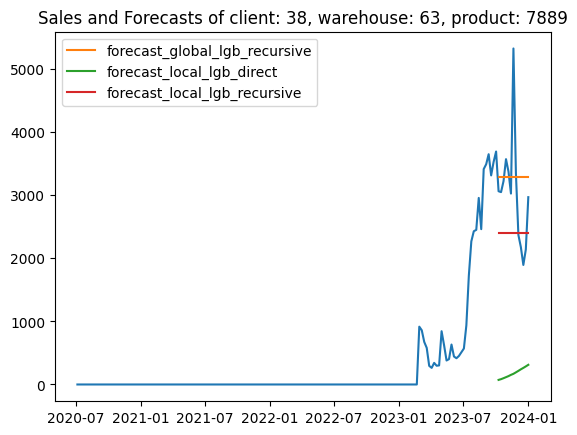

In [240]:
visual_diagnostics('38_63_7889', sales_df, forecast_result_arima, ['forecast_global_lgb_recursive', 'forecast_local_lgb_direct', 'forecast_local_lgb_recursive'])